
# ╔════════════════════════════════════════════════════╗
# ║                 📦 Gap-filled data Exploration and Carbon Budget    ║
# ╚════════════════════════════════════════════════════╝



# ░▒▓ 📦 **1 Python Packages Installation**  ▓▒░

In [7]:
!pip install numpy pandas matplotlib seaborn   # Core data + plotting libs
!pip install tqdm tabulate                     # Progress bar + neat tables

# ░▒▓ 📦 **2 Importing Python Packages**  ▓▒░


In [8]:
import numpy as np                    # arrays, math
import pandas as pd                   # dataframes
import matplotlib.pyplot as plt       # plotting
import matplotlib.dates as mdates     # date ticks
import matplotlib.cm as cm            # colormaps
from matplotlib.lines import Line2D   # legend lines
import seaborn as sns                 # stat plots
from IPython.display import display, HTML   # rich output
# Colab only:
from google.colab import drive        # mount Drive

import warnings                       # silence warnings
warnings.filterwarnings("ignore")

# ░▒▓ 📦 **3 🌿 CO₂ Flux Exploration and Carbon Budgeting**  ▓▒░


Enter your choice (Single, Seasonal, or Tmean): Single
Mounted at /content/drive
Data columns:
Index(['Date Time', 'Year', 'Hour', 'DoY', 'NEE', 'LE', 'H', 'Ustar',
       'qc_co2_flux', 'qc_h2o_flux', 'Net', 'Tair', 'rH', 'Rg', 'Tsoil', 'VPD',
       'Tmean', 'NEE_single_ust_f', 'NEE_single_ust_fqc', 'NEE_seasonal_ust_f',
       'NEE_seasonal_ust_fqc', 'NEE_single_ust_Tmean_f',
       'NEE_single_ust_Tmean_fqc', 'Reco_Tair', 'GPP_Tair', 'GPP_qc_Tair',
       'Reco_Tmean', 'GPP_Tmean', 'GPP_qc_Tmean'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14502 entries, 0 to 14501
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date Time                 14502 non-null  object 
 1   Year                      14502 non-null  int64  
 2   Hour                      14502 non-null  float64
 3   DoY                       14502 non-null  int64  
 4   NEE                     

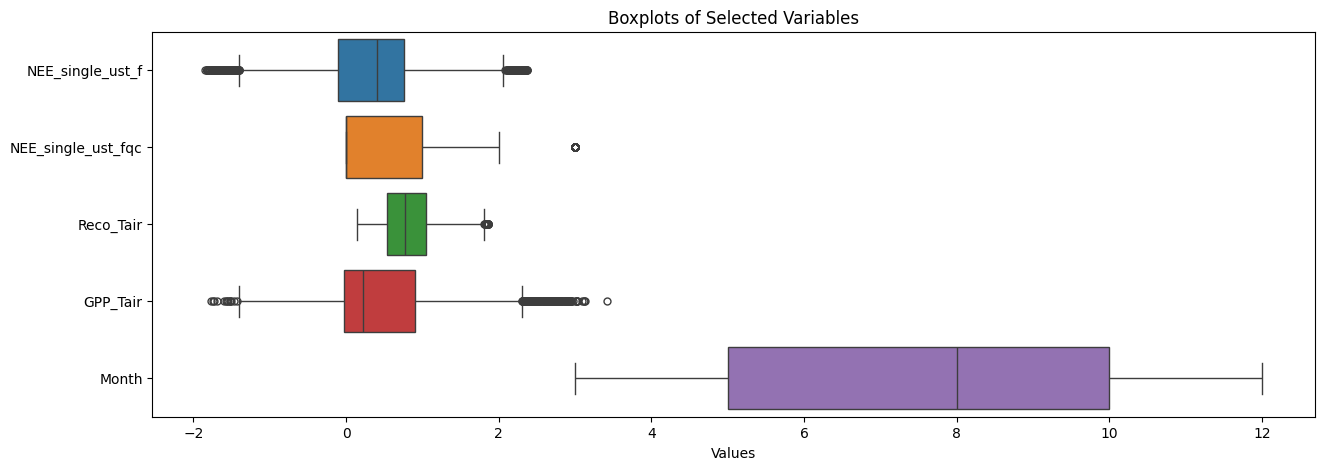



Number of bad quality gap-filled data points: 382


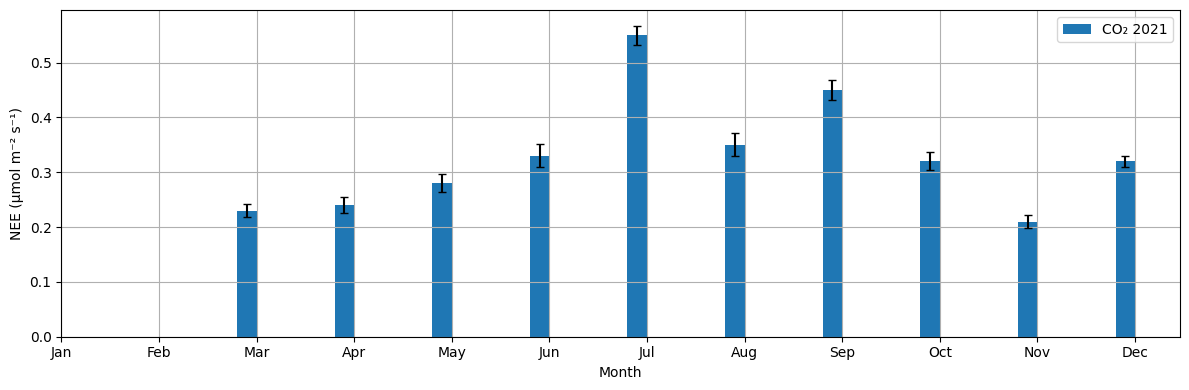

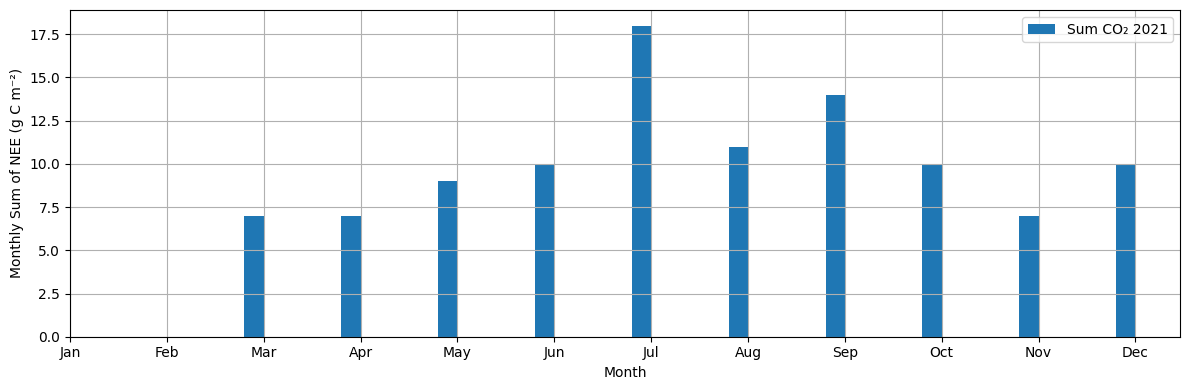

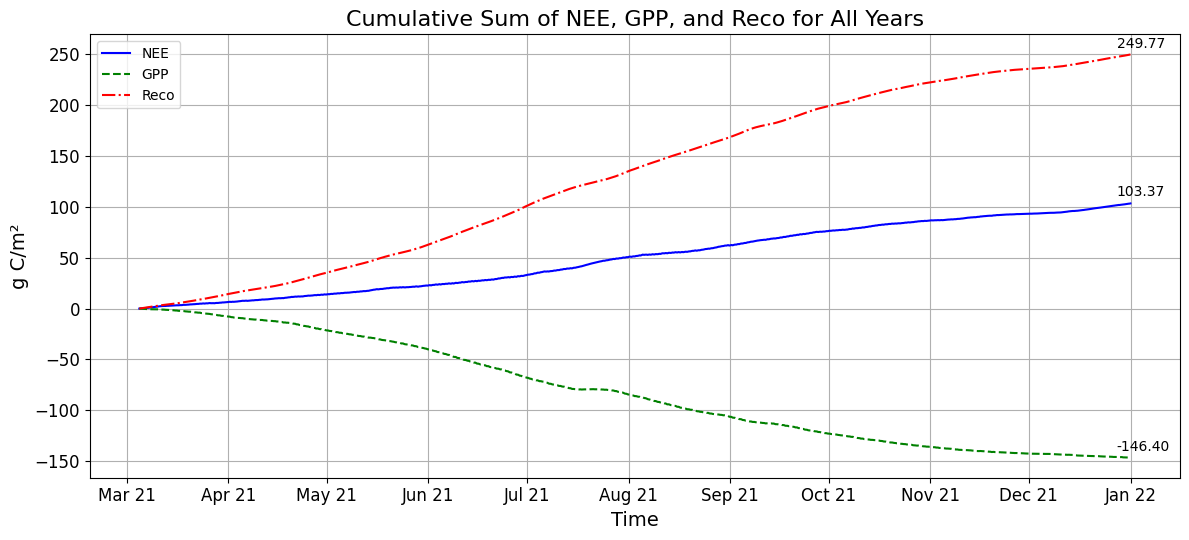

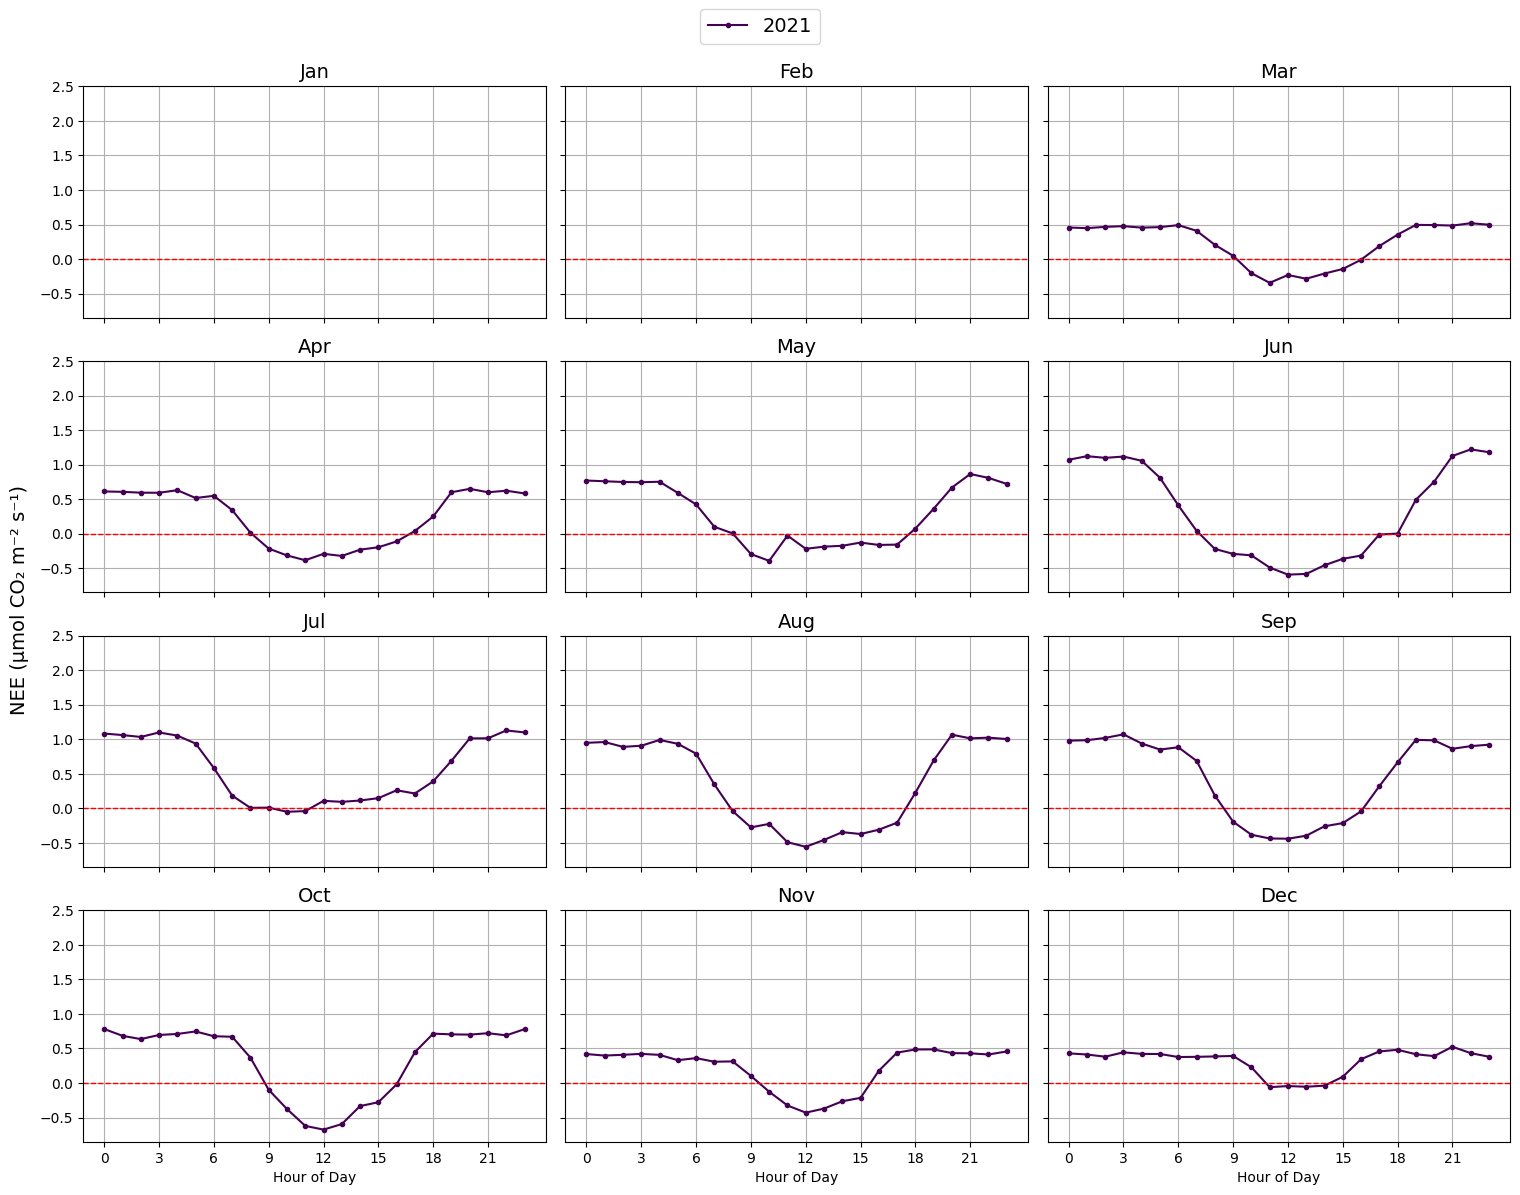

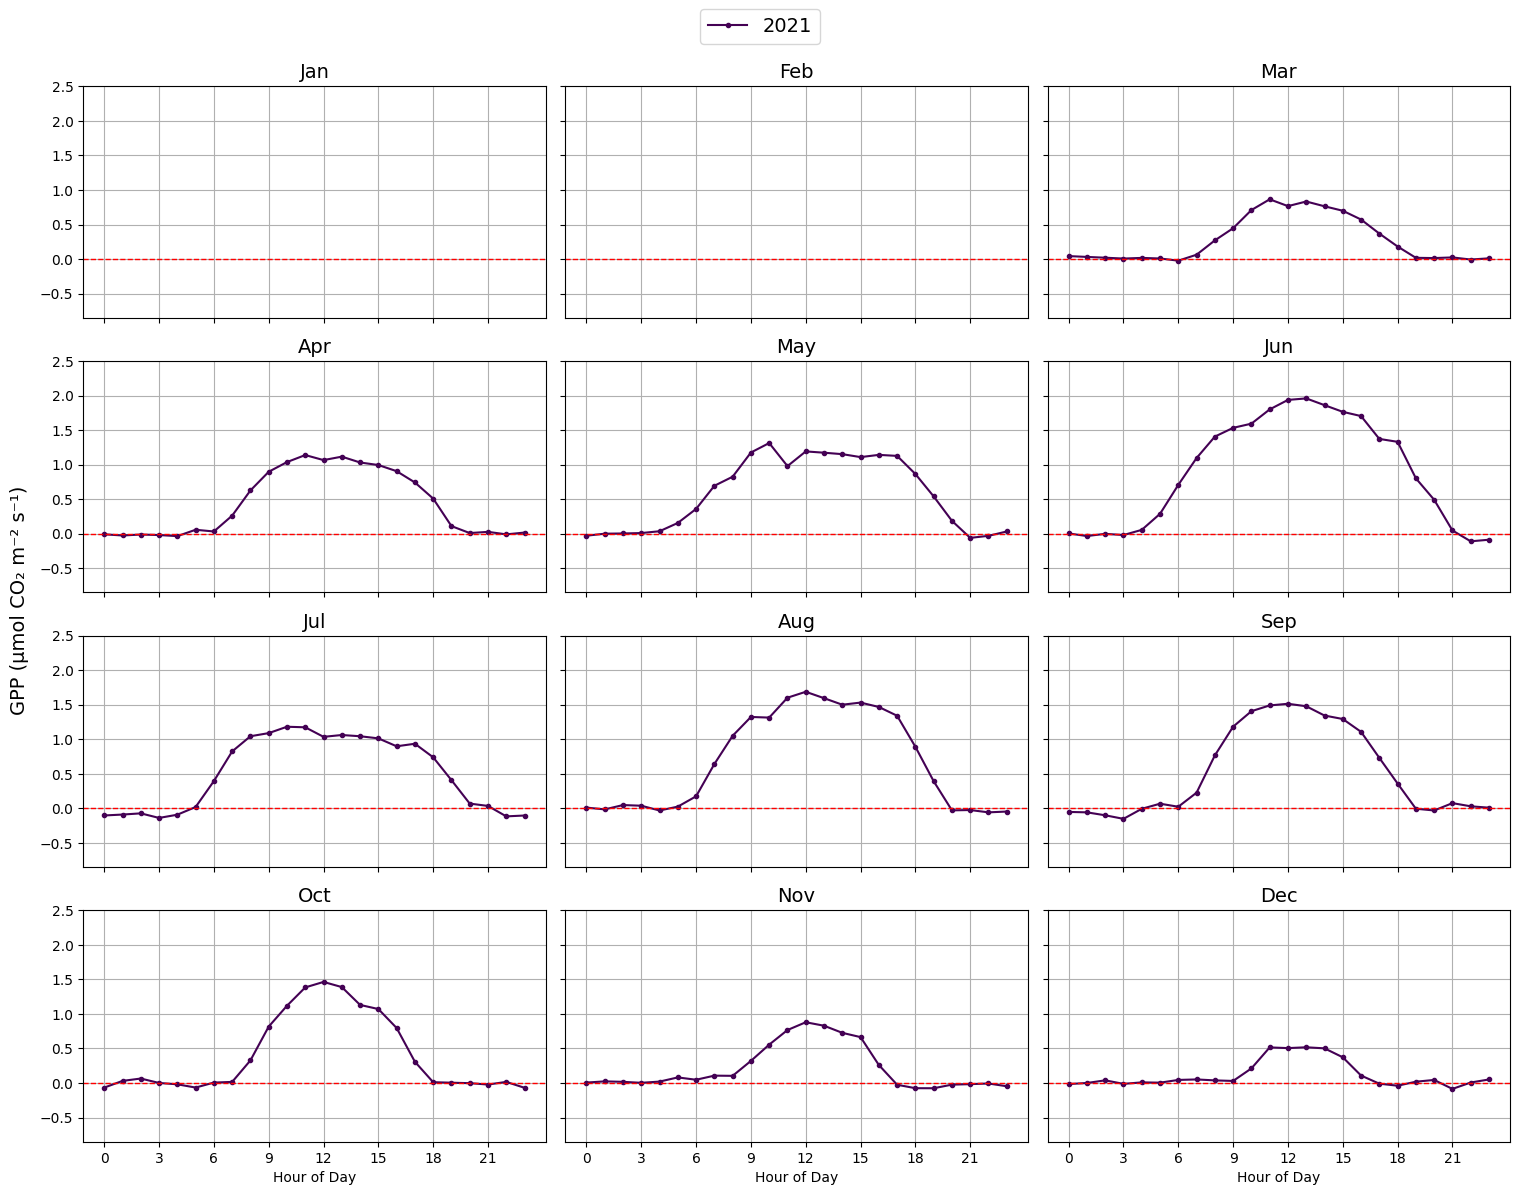

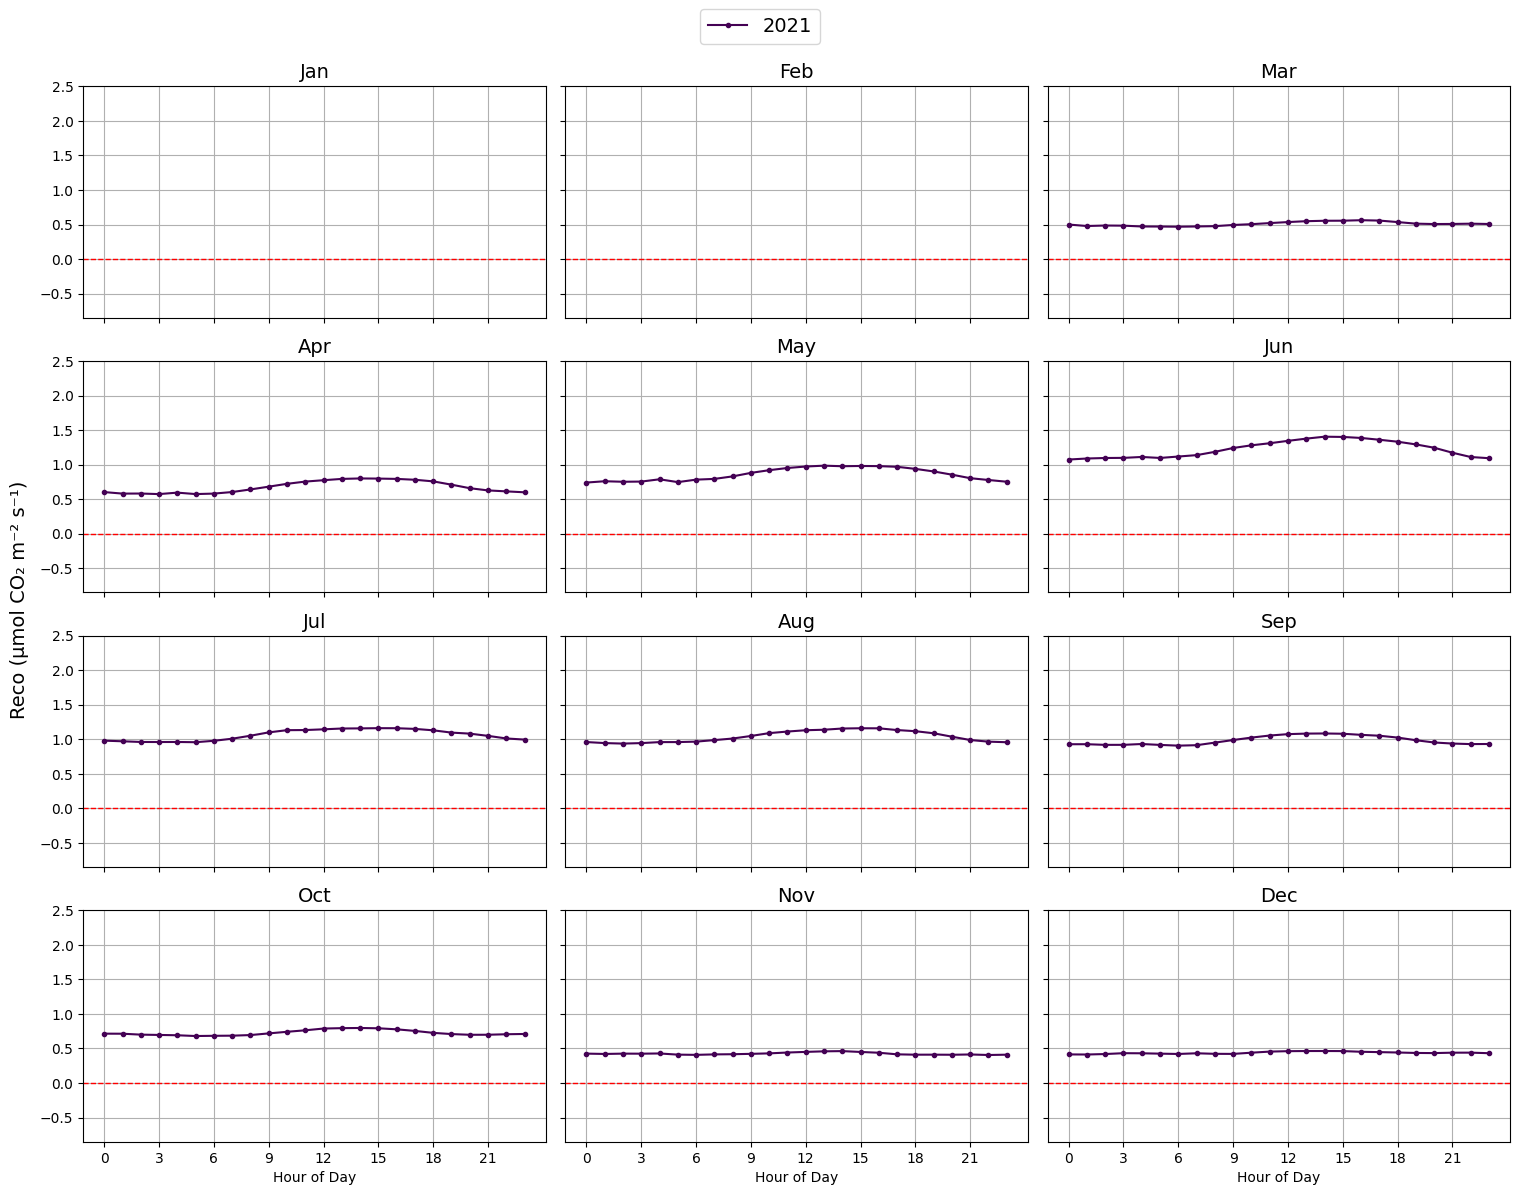

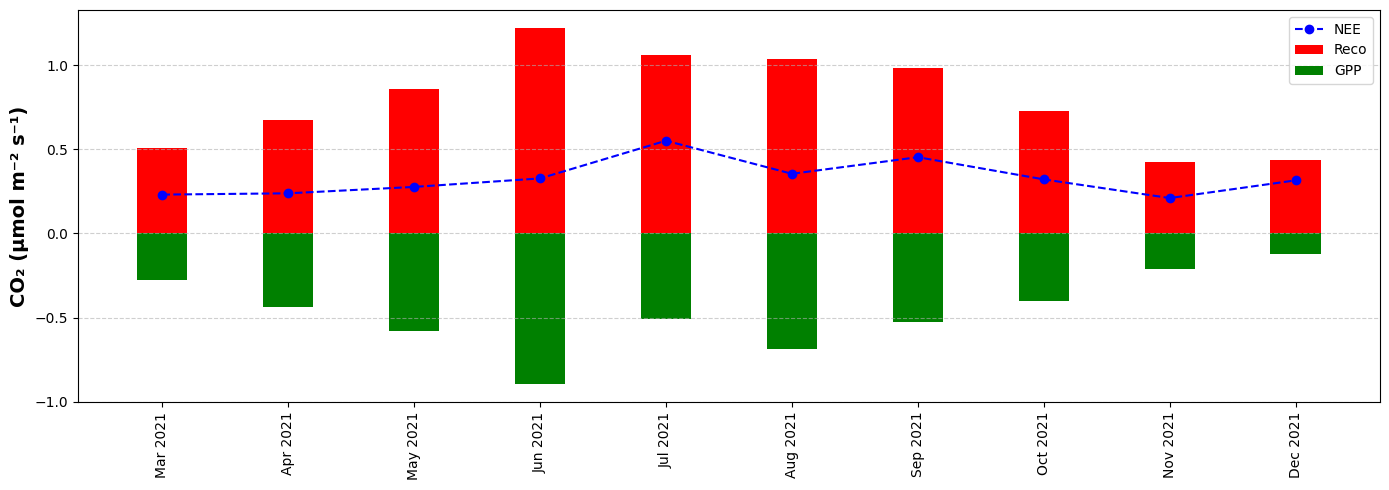

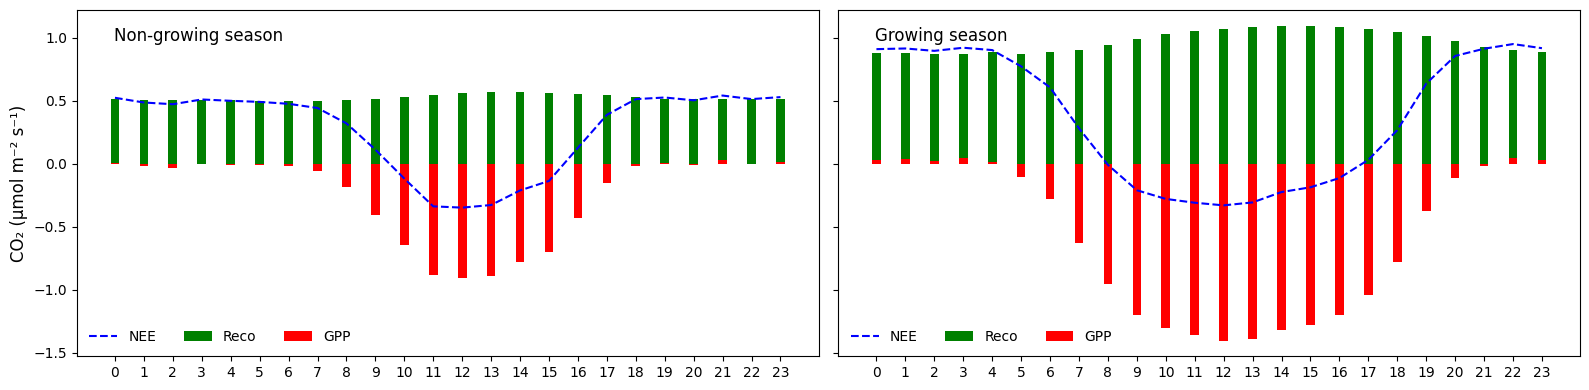



Based on daily mean (u mol CO2 m-2 s-1):
Maximum GPP value: 1.19 in June 2021
Minimum GPP value: -0.12 in July 2021

Maximum NEE value: 0.91 in July 2021
Minimum NEE value: -0.04 in May 2021

Maximum Reco value: 1.5 in June 2021
Minimum Reco value: 0.17 in December 2021


In [9]:
# Display an HTML prompt with a smaller box appearance
display(HTML("""
<div style='display: inline-block; width: 150px; text-align: center; border: 1px solid gray; padding: 5px; margin-bottom: 10px;'>
    <h4 style='color:blue; margin: 5px;'>Select Interest:</h4>
    <p style='color:green; margin: 5px;'>Single, Seasonal, or Tmean</p>
</div>
"""))

# Loop to prompt for valid input until received
while True:
    # Input for user choice
    NEE_interest = input("\nEnter your choice (Single, Seasonal, or Tmean): ").strip()

    # Validate the input
    if NEE_interest in ["Single", "Tmean", "Seasonal"]:
        break
    else:
        print("Invalid input. Please enter 'Single', 'Tmean', or 'Seasonal'.")

# For Google Colab or local data processing, data reading #########################################################################################
from google.colab import drive
drive.mount('/content/drive')
filepath = "/content/Gap-filled-AsiaFlux2025"  # Update with your path
df_raw = pd.read_csv(filepath, sep="\t", skiprows=[1])
# Copy from raw
data = df_raw.copy()

# Exploratory analysis #########################################################################################
print(f"Data columns:\n{data.columns}\n")
print(data.info(), "\n")
print(f"Data shape: {data.shape}\n")
print(f"Missing values:\n{data.isnull().sum()}")

# Data Pre-processing #########################################################################################
data["Date Time"] = pd.to_datetime(data["Date Time"], errors='coerce')
data.set_index("Date Time", inplace=True)
# Selecting columns of interest
df_columns_interest = data[['Year', 'DoY', 'Hour', 'NEE_single_ust_f', 'NEE_single_ust_fqc', 'NEE_seasonal_ust_f',
                          'NEE_seasonal_ust_fqc', 'NEE_single_ust_Tmean_f', 'NEE_single_ust_Tmean_fqc', 'Reco_Tair',
                          'GPP_Tair', 'Reco_Tmean', 'GPP_Tmean']]
data = df_columns_interest.copy()
# Data types checking and conversion if necessary
for i, j in data.dtypes.items():
    if j == "object":
        data[i] = data[i].apply(pd.to_numeric, errors='coerce')
# Set up the DataFrame accordingly based on the choice
if NEE_interest == "Single":
    df_nee = data[['Year', 'DoY', 'Hour', 'NEE_single_ust_f', 'NEE_single_ust_fqc', 'Reco_Tair', 'GPP_Tair']]
elif NEE_interest == "Tmean":
    df_nee = data[['Year', 'DoY', 'Hour', 'NEE_single_ust_Tmean_f', 'NEE_single_ust_Tmean_fqc', 'Reco_Tmean', 'GPP_Tmean']]
elif NEE_interest == "Seasonal":
    df_nee = data[['Year', 'DoY', 'Hour', 'NEE_seasonal_ust_f', 'NEE_seasonal_ust_fqc', 'Reco_Tmean', 'GPP_Tmean']]
# Adding 'Month' and 'Year' columns from the original index for future analysis
df_nee['Month'] = data.index.month
df_nee['Year'] = data.index.year

# Graph 1: Boxplots of Selected Variables ######################################################################################### Box plot
exclude_columns = ['Year', 'DoY', 'Hour']
selected_columns = df_nee.drop(columns=exclude_columns)
plt.figure(figsize=(15, 5))
sns.boxplot(data=selected_columns, orient="h", fliersize=5)
plt.title('Boxplots of Selected Variables')
plt.xlabel('Values')
plt.show()

print('\n')
# Bad quality data points count
col = df_nee.filter(regex='_fqc').columns
bad_quality_count = (df_nee[col] == 3).any(axis=1).sum()
print(f"Number of bad quality gap-filled data points: {bad_quality_count}")

# Graph 2: Monthly NEE Statistics ######################################################################################### Monthly mean with SEM
df = df_nee.copy()
col = df.filter(regex='(_ust_f|_ust_Tmean_f)$').columns[0]
df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=[col])
monthly_stats = df.groupby(['Month', 'Year'])[col].agg(['mean', 'std', 'count']).reset_index().round(2)
monthly_stats['sem'] = monthly_stats['std'] / np.sqrt(monthly_stats['count'])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig2, ax2 = plt.subplots(figsize=(12, 4))
bar_width = 0.2
gap = 0.05
positions = np.arange(len(months)) * (bar_width + gap) * 4
unique_years = sorted(monthly_stats['Year'].unique())
year_positions = {year: positions - (len(unique_years) / 2 - i) * bar_width for i, year in enumerate(unique_years)}
for year in unique_years:
    year_data = monthly_stats[monthly_stats['Year'] == year]
    months_with_data = year_data['Month'] - 1
    means = year_data['mean'].values
    sems = year_data['sem'].values
    ax2.bar(
        [year_positions[year][i] for i in months_with_data],
        means,
        yerr=sems,
        width=bar_width,
        label=f'CO₂ {year}',
        capsize=3
    )
ax2.set_xlabel('Month')
ax2.set_ylabel('NEE (μmol m⁻² s⁻¹)')
ax2.set_xticks(positions)
ax2.set_xticklabels(months)
ax2.grid(True)
ax2.legend()
plt.tight_layout()
plt.show()

# Graph 3: Monthly Total NEE #########################################################################################        Monthly total NEE
df = df_nee.copy()
df[col] = df[col]*1800*10**-6*12
monthly_sum = df.groupby(['Year', 'Month'])[col].sum().reset_index().round()
fig3, ax3 = plt.subplots(figsize=(12, 4))
for year in unique_years:
    year_data = monthly_sum[monthly_sum['Year'] == year]
    months_with_data = year_data['Month'] - 1
    sums = year_data[col].values
    ax3.bar(
        [year_positions[year][i] for i in months_with_data],
        sums,
        width=bar_width,
        label=f'Sum CO₂ {year}',
        capsize=3
    )
ax3.set_xlabel('Month')
ax3.set_ylabel('Monthly Sum of NEE (g C m⁻²)')
ax3.set_xticks(positions)
ax3.set_xticklabels(months)
ax3.grid(True)
ax3.legend()
plt.tight_layout()
plt.show()




# Graph 4: Annual cumulation in g C/m2 #########################################################################################  Annual cumulation in g C/m2
print("\n")
df = df_nee.copy()
# Reco anf GPP columns
col_reco = df.filter(regex='(Reco_)').columns[0]
col_gpp = df.filter(regex='(GPP_)').columns[0]
# Convert umol CO2/m²s to grams of carbon (C) per m²
molar_mass_C = 12.01  # Molar mass of carbon (C) in grams/mol
# Add a new column for the year
df['Year'] = df.index.year
# Get sorted list of unique years and define a colormap
years = sorted(df['Year'].unique())
num_years = len(years)
cmap = cm.get_cmap('viridis', num_years)  # Using 'viridis' for smooth gradient
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(12, 5.5))
# Plot each year with a unique color from the colormap
for i, year in enumerate(years):
    year_data = df[df['Year'] == year].copy()
    color = cmap(i / num_years)  # Scale color based on position in colormap
    # Calculate cumulative values
    year_data['NEE_grams_C'] = year_data[col] * (molar_mass_C / 10**6) * 1800  # 30 mins = 1800 seconds
    year_data['GPP_grams_C'] = -year_data[col_gpp] * (molar_mass_C / 10**6) * 1800  # Convert GPP to negative values
    year_data['Reco_grams_C'] = year_data[col_reco] * (molar_mass_C / 10**6) * 1800  # 30 mins = 1800 seconds
    year_data['NEE_cumulative_grams_C'] = year_data['NEE_grams_C'].cumsum()
    year_data['GPP_cumulative_grams_C'] = year_data['GPP_grams_C'].cumsum()
    year_data['Reco_cumulative_grams_C'] = year_data['Reco_grams_C'].cumsum()
    # Only add labels for the first year to prevent duplicate legend entries
    ax.plot(year_data.index, year_data['NEE_cumulative_grams_C'], color='blue', label='NEE' if i == 0 else "")
    ax.plot(year_data.index, year_data['GPP_cumulative_grams_C'], color='green', linestyle='--', label='GPP' if i == 0 else "")
    ax.plot(year_data.index, year_data['Reco_cumulative_grams_C'], color='red', linestyle='-.', label='Reco' if i == 0 else "")
    # Annotate end values
    ax.annotate(f'{year_data["NEE_cumulative_grams_C"].iloc[-1]:.2f}',
                xy=(year_data.index[-1], year_data['NEE_cumulative_grams_C'].iloc[-1]),
                xytext=(-10, 5), textcoords='offset points', color='black')
    ax.annotate(f'{year_data["GPP_cumulative_grams_C"].iloc[-1]:.2f}',
                xy=(year_data.index[-1], year_data['GPP_cumulative_grams_C'].iloc[-1]),
                xytext=(-10, 5), textcoords='offset points', color='black')
    ax.annotate(f'{year_data["Reco_cumulative_grams_C"].iloc[-1]:.2f}',
                xy=(year_data.index[-1], year_data['Reco_cumulative_grams_C'].iloc[-1]),
                xytext=(-10, 5), textcoords='offset points', color='black')
# Customize x-axis ticks to show abbreviated month and year (e.g., 'Jan 21', 'Feb 22')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))  # %b for month abbrev., %y for year abbrev.
# Add title, labels, and legend
ax.set_title('Cumulative Sum of NEE, GPP, and Reco for All Years', fontsize=16)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('g C/m²', fontsize=14)
ax.legend(fontsize=10)  # Simplified legend without duplicates
# Add grid and display
ax.grid(True)
plt.xticks(fontsize=12, rotation=0)  # Rotate ticks for better readability
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Table
print("\n")
# Create an empty list to store each year's data
summary_list = []
# Loop through each year, calculate cumulative values, and store in the list
for year in years:
    year_data = df[df['Year'] == year].copy()
    # Calculate cumulative values
    year_data['NEE_grams_C'] = year_data[col] * (molar_mass_C / 10**6) * 1800  # Convert and accumulate every 30 mins
    year_data['GPP_grams_C'] = -year_data[col_gpp] * (molar_mass_C / 10**6) * 1800  # Negative GPP values
    year_data['Reco_grams_C'] = year_data[col_reco] * (molar_mass_C / 10**6) * 1800  # Respiration
    # Append cumulative values for the last row of each year
    summary_list.append({
        'Year': year,
        'NEE_cumulative_grams_C': year_data['NEE_grams_C'].cumsum().iloc[-1],
        'GPP_cumulative_grams_C': year_data['GPP_grams_C'].cumsum().iloc[-1],
        'Reco_cumulative_grams_C': year_data['Reco_grams_C'].cumsum().iloc[-1]
    })
# Create the summary table from the list of dictionaries
summary_table = pd.DataFrame(summary_list).round(2)
# Display the summary table
summary_table






# Graph 5: NEE Carbon components (hourly mean) ####################################################################################
df = df_nee.copy()
unique_years = sorted(df['Year'].unique())
num_years = len(unique_years)
colormap = cm.get_cmap('viridis')
markers = {year: '.' for year in unique_years}
colors = {year: colormap(i / num_years) for i, year in enumerate(unique_years)}
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    for year in unique_years:
        monthly_data = df[(df['Month'] == month) & (df['Year'] == year)]
        if not monthly_data.empty:
            hourly_mean = monthly_data.groupby(monthly_data.index.hour)[col].mean()
            ax.plot(hourly_mean.index, hourly_mean.values, label=f'{year}', marker=markers[year], color=colors[year])
    ax.set_title(months[i], fontsize=14)
    ax.grid(True)
    ax.axhline(0, color='red', linewidth=1, linestyle='--')
    ax.set_ylim(-0.85, 2.5)
    ax.set_yticks(np.arange(-0.5, 3.0, 0.5))
    ax.set_xticks(np.arange(0, 24, 3))
    if i >= 9:
        ax.set_xlabel('Hour of Day')
fig.text(-0.01, 0.5, 'NEE (μmol CO₂ m⁻² s⁻¹)', va='center', rotation='vertical', fontsize=14)
legend_elements = [Line2D([0], [0], color=colors[year], marker=markers[year], linestyle='-', label=str(year)) for year in unique_years]
fig.legend(handles=legend_elements, loc='upper center', ncol=min(num_years, 4), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()





# Graph 6: GPP Carbon components (hourly mean) ####################################################################################
print("\n")
df = df_nee.copy()
unique_years = sorted(df['Year'].unique())
num_years = len(unique_years)
colormap = cm.get_cmap('viridis')
markers = {year: '.' for year in unique_years}
colors = {year: colormap(i / num_years) for i, year in enumerate(unique_years)}
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    for year in unique_years:
        monthly_data = df[(df['Month'] == month) & (df['Year'] == year)]
        if not monthly_data.empty:
            hourly_mean = monthly_data.groupby(monthly_data.index.hour)[col_gpp].mean()
            ax.plot(hourly_mean.index, hourly_mean.values, label=f'{year}', marker=markers[year], color=colors[year])
    ax.set_title(months[i], fontsize=14)
    ax.grid(True)
    ax.axhline(0, color='red', linewidth=1, linestyle='--')
    ax.set_ylim(-0.85, 2.5)
    ax.set_yticks(np.arange(-0.5, 3.0, 0.5))
    ax.set_xticks(np.arange(0, 24, 3))
    if i >= 9:
        ax.set_xlabel('Hour of Day')
fig.text(-0.01, 0.5, 'GPP (μmol CO₂ m⁻² s⁻¹)', va='center', rotation='vertical', fontsize=14)
legend_elements = [Line2D([0], [0], color=colors[year], marker=markers[year], linestyle='-', label=str(year)) for year in unique_years]
fig.legend(handles=legend_elements, loc='upper center', ncol=min(num_years, 4), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()






# Graph 7: GPP Carbon components (hourly mean) ####################################################################################
print("\n")
df = df_nee.copy()
unique_years = sorted(df['Year'].unique())
num_years = len(unique_years)
colormap = cm.get_cmap('viridis')
markers = {year: '.' for year in unique_years}
colors = {year: colormap(i / num_years) for i, year in enumerate(unique_years)}
fig, axes = plt.subplots(4, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
for i, month in enumerate(range(1, 13)):
    ax = axes[i]
    for year in unique_years:
        monthly_data = df[(df['Month'] == month) & (df['Year'] == year)]
        if not monthly_data.empty:
            hourly_mean = monthly_data.groupby(monthly_data.index.hour)[col_reco].mean()
            ax.plot(hourly_mean.index, hourly_mean.values, label=f'{year}', marker=markers[year], color=colors[year])
    ax.set_title(months[i], fontsize=14)
    ax.grid(True)
    ax.axhline(0, color='red', linewidth=1, linestyle='--')
    ax.set_ylim(-0.85, 2.5)
    ax.set_yticks(np.arange(-0.5, 3.0, 0.5))
    ax.set_xticks(np.arange(0, 24, 3))
    if i >= 9:
        ax.set_xlabel('Hour of Day')
fig.text(-0.01, 0.5, 'Reco (μmol CO₂ m⁻² s⁻¹)', va='center', rotation='vertical', fontsize=14)
legend_elements = [Line2D([0], [0], color=colors[year], marker=markers[year], linestyle='-', label=str(year)) for year in unique_years]
fig.legend(handles=legend_elements, loc='upper center', ncol=min(num_years, 4), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()





'''

# Graph 8. Seasonal variation based on daily mean #################################################################################################
print("\n")
df = df_nee.copy()
# Resample to daily and calculate mean
daily_mean = df.resample('D').mean()
# Print the daily mean NEE
#print(daily_mean)
# Get the unique years from the dataset
unique_years = daily_mean['Year'].unique()
# Create a figure and subplots (1 row, number of unique years columns)
fig, axs = plt.subplots(1, len(unique_years), figsize=(18, 5), sharey=True)
# Initialize handles for the legends
data_handles = []
shaded_handles = []
# Loop through each unique year to create subplots
for i, year in enumerate(unique_years):
    # Filter the data for the current year
    daily_mean_year = daily_mean[daily_mean['Year'] == year]
    # Plot NEE, Reco, and GPP for the current year
    line1, = axs[i].plot(daily_mean_year['DoY'], daily_mean_year[col], label='NEE', color='blue')
    line2, = axs[i].plot(daily_mean_year['DoY'], daily_mean_year[col_reco], label='Reco', color='green')
    line3, = axs[i].plot(daily_mean_year['DoY'], -daily_mean_year[col_gpp], label='GPP', color='red')
    # Collect handles for the data lines
    data_handles.extend([line1, line2, line3])
    # Shading the non-growing season (October to March: DoY 1 to 90 and 274 to 365)
    axs[i].axvspan(1, 90, color='lightgrey', alpha=0.5)   # Jan to Mar
    axs[i].axvspan(274, 365, color='lightgrey', alpha=0.5)  # Oct to Dec
    # Shading the growing season (April to September: DoY 91 to 273)
    axs[i].axvspan(91, 273, color='lightgreen', alpha=0.3)
    # Set titles and labels
    axs[i].set_title(f'{round(year)}')
    axs[i].set_xlabel('Day of Year')
    axs[i].axhline(y=0, color='black', linestyle='--', linewidth=1)
    axs[i].set_xticks(range(0, 366, 30))  # Set x-axis ticks every 25 days
# Set a common ylabel for all subplots
axs[0].set_ylabel(r'CO$_2$ Flux (µ mol CO$_2$ m$^{-2}$ s$^{-1}$)')
# Create a single common legend for NEE, Reco, and GPP, positioned below the subplots
fig.legend(data_handles, ['NEE', 'Reco', 'GPP'], loc='lower center', fontsize = 11, bbox_to_anchor=(0.35, -0.07), ncol=3)
# Create a common legend for shaded regions
shaded_handles = [
    plt.Line2D([0], [0], color='lightgrey', lw=6, alpha=0.5, label='Non-growing Season'),
    plt.Line2D([0], [0], color='lightgreen', lw=6, alpha=0.5, label='Growing Season'),
]
# Use fig.legend with both handles and labels
fig.legend(shaded_handles, ['Non-growing Season', 'Growing Season'], loc='lower center', bbox_to_anchor=(0.6, -0.07), ncol=2)
# Adjust layout to prevent overlap between subplots and the legends
plt.tight_layout()
# Show plot
plt.show()
'''




# Graph 9. Temporal variation based on Monthly mean ############################################################################################################
print("\n")
df = df_nee.copy()
# Resample to monthly means
monthly_mean = df.resample("M").mean()
# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 5))
# Plot the bar chart for Reco (green) and GPP (red)
bar_width = 0.4
r1 = range(len(monthly_mean))
# Plot Reco (positive)
ax.bar(r1, monthly_mean[col_reco], color='red', width=bar_width, label='Reco')
# Plot GPP (negative)
ax.bar(r1, -monthly_mean[col_gpp], color='green', width=bar_width, label='GPP')
# Plot NEE (line with markers)
ax.plot(r1, monthly_mean[col], color='blue', linestyle='--', marker='o', label='NEE')
# Adjusting the x-axis to include both month and year for clarity
ax.set_xticks(r1)
ax.set_xticklabels([x.strftime('%b %Y') for x in monthly_mean.index], rotation=90, fontsize=10)
# Adding labels
#ax.set_xlabel('Month and Year', fontweight='bold', fontsize=14)
ax.set_ylabel('CO₂ (µmol m⁻² s⁻¹)', fontweight='bold', fontsize=14)
#ax.set_title('Monthly Mean Values for NEE, Reco, and GPP', fontweight='bold', fontsize=16)
# Adding grid
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.6)
# Create legend
ax.legend()
# Tight layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()







# Graph 10. Diurnal variation based on Hourly mean ############################################################################################################
print("\n")
df = df_nee.copy()
# Resample the data to hourly means
hourly_means = df.resample('H').mean()
# Define the two seasons
growing_season = ['04', '05', '06', '07', '08', '09']  # April to September
non_growing_season = ['10', '11', '12', '01', '02', '03']  # October to March
# Customize figure size
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
# Define specific hours for x-ticks
x_tick_hours = range(0, 24)  # Hourly ticks
# Plot for Non-Growing Season (October to March)
non_growing_data = hourly_means[hourly_means.index.month.astype(str).str.zfill(2).isin(non_growing_season)]
mean_nee = non_growing_data.groupby(non_growing_data.index.hour)[col].mean()
mean_gpp = -non_growing_data.groupby(non_growing_data.index.hour)[col_gpp].mean()  # GPP is plotted downwards
mean_reco = non_growing_data.groupby(non_growing_data.index.hour)[col_reco].mean()

# Bar plot for GPP and Reco, Line plot for NEE
axs[0].bar(mean_nee.index, mean_reco, width=0.3, color='green', label='Reco')
axs[0].bar(mean_nee.index, mean_gpp, width=0.3, color='red', label='GPP')
axs[0].plot(mean_nee.index, mean_nee, linestyle='--', color='blue', label='NEE')

# Add custom text inside the first subplot for "Non-growing season" in lower right
axs[0].text(0.05, 0.95, 'Non-growing season',
            transform=axs[0].transAxes,  # Use axis coordinates for positioning
            fontsize=12, color='black', ha='left', va='top')
# Set labels and legend
#axs[0].set_xlabel('Hour of the Day', fontsize=12)
axs[0].set_ylabel('CO₂ (μmol m⁻² s⁻¹)', fontsize=12)
axs[0].legend(loc='lower left', bbox_to_anchor=(0, 0), ncol=4, frameon=False)
axs[0].set_xticks(x_tick_hours)
# Plot for Growing Season (April to September)
growing_data = hourly_means[hourly_means.index.month.astype(str).str.zfill(2).isin(growing_season)]
mean_nee = growing_data.groupby(growing_data.index.hour)[col].mean()
mean_gpp = -growing_data.groupby(growing_data.index.hour)[col_gpp].mean()  # GPP is plotted downwards
mean_reco = growing_data.groupby(growing_data.index.hour)[col_reco].mean()
# Bar plot for GPP and Reco, Line plot for NEE
axs[1].bar(mean_nee.index, mean_reco, width=0.3, color='green', label='Reco')
axs[1].bar(mean_nee.index, mean_gpp, width=0.3, color='red', label='GPP')
axs[1].plot(mean_nee.index, mean_nee, linestyle='--', color='blue', label='NEE')
# Add custom text inside the second subplot for "Growing season" in lower right
axs[1].text(0.05, 0.95, 'Growing season',
            transform=axs[1].transAxes,  # Use axis coordinates for positioning
            fontsize=12, color='black', ha='left', va='top')
# Set labels and legend
#axs[1].set_xlabel('Hour of the Day', fontsize=12)
axs[1].legend(loc='lower left', bbox_to_anchor=(0, 0), ncol=4, frameon=False)
axs[1].set_xticks(x_tick_hours)
# Adjust layout
plt.tight_layout()
plt.show()




# 11 Calculate daily average for each flux (selecting only numeric columns) ######################################################### Daily mean max min
print("\n")
print("Based on daily mean (u mol CO2 m-2 s-1):")
df = df_nee.copy()
daily_df = df[[col, col_reco, col_gpp]].resample('D').mean()

# Find the minimum and maximum values for GPP, NEE, and Reco, including month and year
max_gpp_value = round(daily_df[col_gpp].max(), 2)
max_gpp_date = daily_df[col_gpp].idxmax()
max_gpp_month_year = max_gpp_date.strftime('%B %Y')
min_gpp_value = round(daily_df[col_gpp].min(), 2)
min_gpp_date = daily_df[col_gpp].idxmin()
min_gpp_month_year = min_gpp_date.strftime('%B %Y')

max_nee_value = round(daily_df[col].max(), 2)
max_nee_date = daily_df[col].idxmax()
max_nee_month_year = max_nee_date.strftime('%B %Y')
min_nee_value = round(daily_df[col].min(), 2)
min_nee_date = daily_df[col].idxmin()
min_nee_month_year = min_nee_date.strftime('%B %Y')

max_reco_value = round(daily_df[col_reco].max(), 2)
max_reco_date = daily_df[col_reco].idxmax()
max_reco_month_year = max_reco_date.strftime('%B %Y')
min_reco_value = round(daily_df[col_reco].min(), 2)
min_reco_date = daily_df[col_reco].idxmin()
min_reco_month_year = min_reco_date.strftime('%B %Y')

# Print the results
print(f"Maximum GPP value: {max_gpp_value} in {max_gpp_month_year}")
print(f"Minimum GPP value: {min_gpp_value} in {min_gpp_month_year}")
print("")

print(f"Maximum NEE value: {max_nee_value} in {max_nee_month_year}")
print(f"Minimum NEE value: {min_nee_value} in {min_nee_month_year}")
print("")

print(f"Maximum Reco value: {max_reco_value} in {max_reco_month_year}")
print(f"Minimum Reco value: {min_reco_value} in {min_reco_month_year}")